In [1]:
import statsmodels as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme(style="darkgrid")

In [2]:
comp_prices_df = pd.read_csv("../data/comp_prices.csv")
sales_df = pd.read_csv("../data/sales.csv")


In [3]:
comp_prices_df.columns = list(map(str.lower, comp_prices_df.columns))
comp_prices_df["date_extraction"] = pd.to_datetime(comp_prices_df["date_extraction"])
comp_prices_df["date"] = pd.to_datetime(comp_prices_df["date_extraction"].dt.date)
comp_prices_df

,prod_id,date_extraction,competitor,competitor_price,pay_type,date
0,P6,2015-01-30 08:11:38,C3,1898.00,1,2015-01-30
1,P6,2015-01-30 08:11:38,C1,1898.00,1,2015-01-30
2,P6,2015-01-30 08:11:38,C6,1999.90,1,2015-01-30
3,P6,2015-01-31 20:10:14,C2,1894.88,2,2015-01-31
4,P6,2015-01-31 20:10:14,C3,1894.88,2,2015-01-31
...,...,...,...,...,...,...
50109,P5,2015-10-11 20:10:34,C1,819.00,2,2015-10-11
50110,P5,2015-10-11 20:10:34,C2,853.52,2,2015-10-11
50111,P5,2015-10-12 08:11:27,C2,853.52,1,2015-10-12
50112,P5,2015-10-12 08:11:27,C3,819.00,1,2015-10-12


In [4]:
sales_df.columns = list(map(str.lower, sales_df.columns))
sales_df["date_order"] = pd.to_datetime(sales_df.date_order)
sales_df["value_per_item"] = sales_df.revenue/sales_df.qty_order

sales_df = sales_df.groupby(["prod_id", "date_order", "value_per_item"]).agg({"qty_order" : "sum"}).reset_index()

day_agg = sales_df.groupby(["prod_id", "date_order"])\
         .agg({"qty_order" : "sum"})\
         .rename(columns={"qty_order" : "qty_day"})\
         .reset_index()

sales_df = pd.merge(sales_df,
        day_agg,
        on=["prod_id", "date_order"])

sales_df["value_per_item"] = sales_df.qty_order/sales_df.qty_day*sales_df.value_per_item
sales_df = sales_df.groupby(["prod_id", "date_order"]).agg({"value_per_item" : "sum", "qty_order" : "sum"}).reset_index()

In [5]:
all_prices = pd.concat([
    comp_prices_df\
    .rename(columns = {"competitor_price" : "price"})[["prod_id", "date", "price"]],
  #  sales_df[["prod_id", "date_order", "value_per_item"]].rename(columns={"value_per_item" : "price",
  #                                                                        "date_order"     : "date"})
])

df = pd.merge(sales_df.rename(columns={"date_order":"date"})\
             .groupby(["prod_id",
                            "date",
                            "value_per_item"])\
             .agg({"qty_order" : "sum"})\
             .reset_index(),
          all_prices.groupby(["prod_id","date"])\
              .price.agg(["min","max","mean", "median"])\
              .reset_index(),
         on=["date", "prod_id"]
          )
df

,prod_id,date,value_per_item,qty_order,min,max,mean,median
0,P1,2015-03-15,1360.768542,48.0,1499.00,1499.0,1499.000000,1499.000
1,P1,2015-03-16,1402.312500,24.0,1362.50,1499.0,1464.205000,1499.000
2,P1,2015-03-17,1355.201071,28.0,1362.50,1499.0,1429.792857,1424.050
3,P1,2015-03-18,1358.555075,67.0,1362.50,1499.0,1441.008333,1461.525
4,P1,2015-03-19,1355.095217,46.0,1304.13,1499.0,1407.363333,1391.525
...,...,...,...,...,...,...,...,...
1916,P9,2015-10-10,391.380233,129.0,395.82,569.0,420.713000,395.850
1917,P9,2015-10-11,390.586437,87.0,395.78,569.0,420.701000,395.825
1918,P9,2015-10-12,391.779727,110.0,395.76,569.0,420.673000,395.780
1919,P9,2015-10-13,380.636555,328.0,393.00,569.0,419.407500,394.000


In [6]:
day_agg = df.groupby(["prod_id", "date"])\
         .agg({"qty_order" : "sum"})\
         .rename(columns={"qty_order" : "qty_day"})\
         .reset_index()
day_agg["qty_day_mm"] = day_agg.groupby(["prod_id"]).qty_day.transform(lambda s: s.rolling(14, min_periods=14).median())

In [11]:
df = pd.merge(df,
        day_agg,
        on=["prod_id", "date"])


day_agg_shift = day_agg
day_agg_shift["date"]  = day_agg_shift["date"].apply(lambda x: x + pd.Timedelta(days=1))
day_agg_shift.rename(columns={"qty_day": "qty_day_shift",
                             "qty_day_mm": "qty_day_shift_mm"}, inplace=True)
df = pd.merge(df,
              day_agg_shift,
        on=["prod_id", "date"])
df["diff_min_pct"] = (df.value_per_item - df["min"])/df["min"]
df["diff_mean_pct"] = (df.value_per_item - df["mean"])/df["mean"]
df["pct_of_qty_day"] = df.qty_order / df.qty_day
df["qty_order_log"] = np.log(df.qty_order)

In [12]:
day_agg

,prod_id,date,qty_day_shift,qty_day_shift_mm
0,P1,2015-03-17,48.0,NaN
1,P1,2015-03-18,24.0,NaN
2,P1,2015-03-19,28.0,NaN
3,P1,2015-03-20,67.0,NaN
4,P1,2015-03-21,46.0,NaN
...,...,...,...,...
1916,P9,2015-10-12,129.0,154.5
1917,P9,2015-10-13,87.0,154.5
1918,P9,2015-10-14,110.0,134.0
1919,P9,2015-10-15,328.0,134.0


In [13]:
df

,prod_id,date,value_per_item,qty_order,min,max,mean,median,qty_day,qty_day_mm,qty_day_shift_x,qty_day_shift_mm_x,diff_min_pct,diff_mean_pct,pct_of_qty_day,qty_day_shift_y,qty_day_shift_mm_y,qty_day_shift,qty_day_shift_mm,qty_order_log
0,P1,2015-03-17,1355.201071,28.0,1362.50,1499.0,1429.792857,1424.050,28.0,NaN,24.0,NaN,-0.005357,-0.052170,1.0,24.0,NaN,48.0,NaN,3.332205
1,P1,2015-03-18,1358.555075,67.0,1362.50,1499.0,1441.008333,1461.525,67.0,NaN,28.0,NaN,-0.002895,-0.057219,1.0,28.0,NaN,24.0,NaN,4.204693
2,P1,2015-03-19,1355.095217,46.0,1304.13,1499.0,1407.363333,1391.525,46.0,NaN,67.0,NaN,0.039080,-0.037139,1.0,67.0,NaN,28.0,NaN,3.828641
3,P1,2015-03-20,1384.065789,19.0,1304.13,1499.0,1439.727143,1499.000,19.0,NaN,46.0,NaN,0.061294,-0.038661,1.0,46.0,NaN,67.0,NaN,2.944439
4,P1,2015-03-21,1424.504167,12.0,1359.00,1499.0,1439.841667,1461.525,12.0,NaN,19.0,NaN,0.048200,-0.010652,1.0,19.0,NaN,46.0,NaN,2.484907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,P9,2015-10-10,391.380233,129.0,395.82,569.0,420.713000,395.850,129.0,154.5,175.0,154.5,-0.011217,-0.069722,1.0,175.0,154.5,370.0,154.5,4.859812
1859,P9,2015-10-11,390.586437,87.0,395.78,569.0,420.701000,395.825,87.0,154.5,129.0,154.5,-0.013122,-0.071582,1.0,129.0,154.5,175.0,154.5,4.465908
1860,P9,2015-10-12,391.779727,110.0,395.76,569.0,420.673000,395.780,110.0,134.0,87.0,154.5,-0.010057,-0.068683,1.0,87.0,154.5,129.0,154.5,4.700480
1861,P9,2015-10-13,380.636555,328.0,393.00,569.0,419.407500,394.000,328.0,134.0,110.0,134.0,-0.031459,-0.092442,1.0,110.0,134.0,87.0,154.5,5.793014


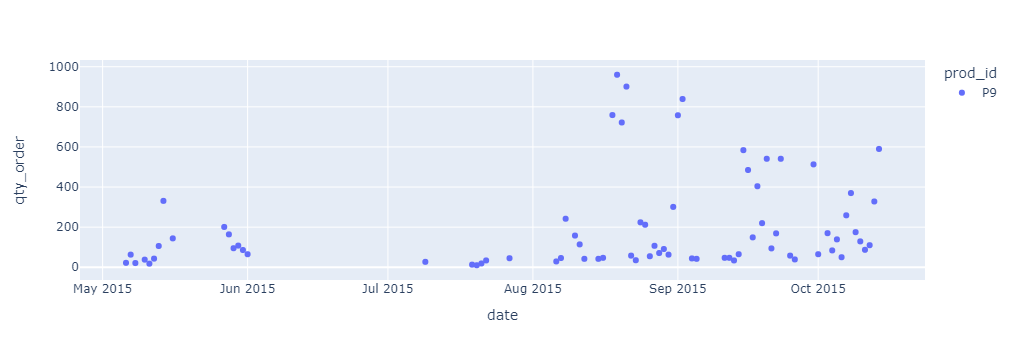

In [14]:
px.scatter(df[ (df.value_per_item < df["min"]*1.05) & (df.prod_id == "P9")].groupby(["prod_id", "date"]).agg({"qty_order" : "sum"}).reset_index(),
        x="date",
        y="qty_order",
        color="prod_id")

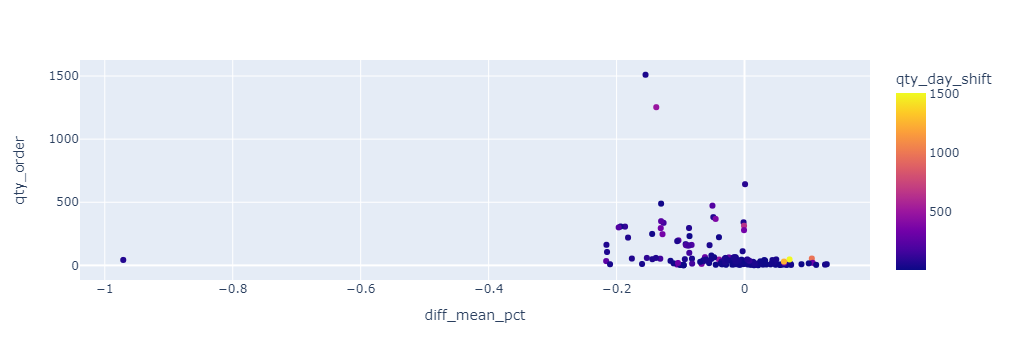

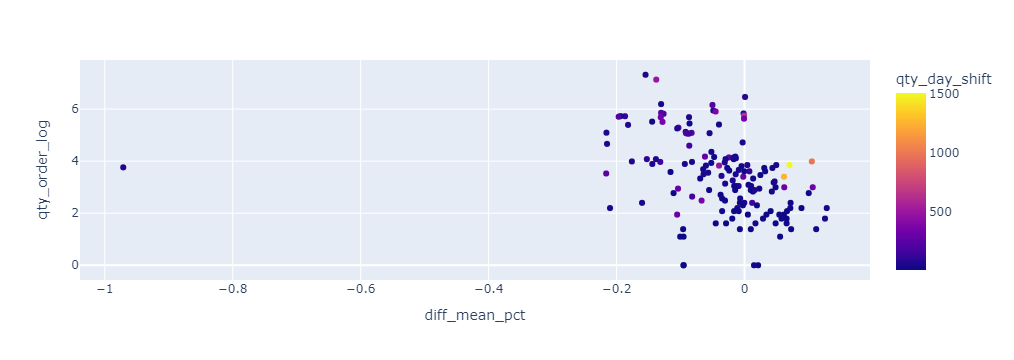

In [21]:
prod_id = "P4"
fig = px.scatter(df[df.prod_id == prod_id], x="diff_mean_pct", y="qty_order", color="qty_day_shift")
fig.show()

fig = px.scatter(df[df.prod_id == prod_id], x="diff_mean_pct", y="qty_order_log", color="qty_day_shift")
fig.show()


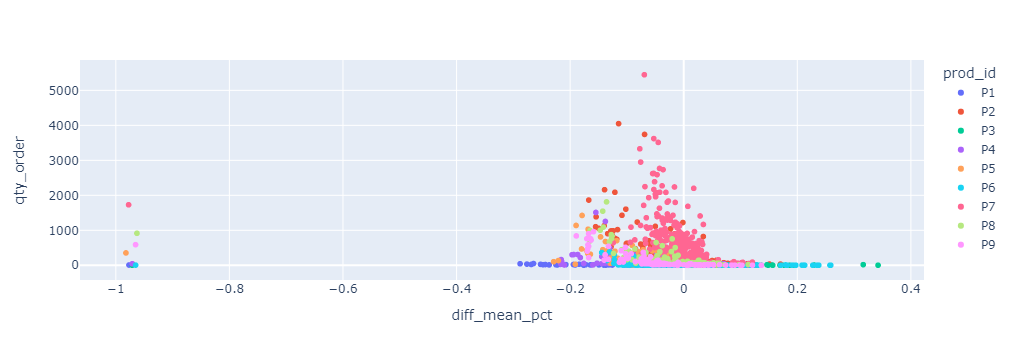

In [23]:
px.scatter(df, x="diff_mean_pct", y="qty_order", color="prod_id")

In [22]:
df

,prod_id,date,value_per_item,qty_order,min,max,mean,median,qty_day,qty_day_mm,qty_day_shift,qty_day_shift_mm,diff_min_pct,diff_mean_pct,pct_of_qty_day
0,P1,2015-03-16,1402.312500,24.0,1362.50,1499.0,1464.205000,1499.000,24.0,36.0,48.0,48.0,0.029220,-0.042270,1.0
1,P1,2015-03-17,1355.201071,28.0,1362.50,1499.0,1429.792857,1424.050,28.0,28.0,24.0,36.0,-0.005357,-0.052170,1.0
2,P1,2015-03-18,1358.555075,67.0,1362.50,1499.0,1441.008333,1461.525,67.0,38.0,28.0,28.0,-0.002895,-0.057219,1.0
3,P1,2015-03-19,1355.095217,46.0,1304.13,1499.0,1407.363333,1391.525,46.0,46.0,67.0,38.0,0.039080,-0.037139,1.0
4,P1,2015-03-20,1384.065789,19.0,1304.13,1499.0,1439.727143,1499.000,19.0,37.0,46.0,46.0,0.061294,-0.038661,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887,P9,2015-10-10,391.380233,129.0,395.82,569.0,420.713000,395.850,129.0,154.5,175.0,154.5,-0.011217,-0.069722,1.0
1888,P9,2015-10-11,390.586437,87.0,395.78,569.0,420.701000,395.825,87.0,154.5,129.0,154.5,-0.013122,-0.071582,1.0
1889,P9,2015-10-12,391.779727,110.0,395.76,569.0,420.673000,395.780,110.0,134.0,87.0,154.5,-0.010057,-0.068683,1.0
1890,P9,2015-10-13,380.636555,328.0,393.00,569.0,419.407500,394.000,328.0,134.0,110.0,134.0,-0.031459,-0.092442,1.0
